In [19]:
# Experiment: Masked sinusoid across multiple signals, FFT detection, subtraction, and recovery
# Notes for the user:
# - Uses matplotlib only, one chart per figure (no subplots, no custom colors).
# - Saves all figures to /mnt/data and also displays them inline.
# - You can download any of the PNGs using the links I'll provide after this cell runs.

import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import rfft, rfftfreq, irfft, ifft
import os

# Create output directory if it doesn't exist
os.makedirs('./output', exist_ok=True)

rng = np.random.default_rng(42)

def save_and_show(fig, filename):
    fig.savefig(filename, dpi=160, bbox_inches='tight')
    plt.show()

In [2]:
# -----------------------------
# 1) Parameters you can tweak
# -----------------------------
fs = 500                 # sampling rate (Hz)
T  = 1.2                 # duration (s) -> short so bin width ~ 0.83 Hz
N  = int(fs * T)
t  = np.arange(N) / fs

# Four base sinusoids (amp, freq, phase)
base = [
    (1.8,  8.0,  0.2*np.pi),
    (1.2, 15.7, -0.5*np.pi),
    (1.6, 24.5,  0.8*np.pi),
    (0.9, 33.2,  0.0),
]

noise_sigma = 0.5        # fairly strong white noise
# Hidden ("5th") sinusoid
A5   = 0.9
f5   = 17.3              # non-bin-aligned to smear when fragmented
phi5 = 0.37*np.pi

# Per-sample assignment probabilities for the hidden component
p_skip = 0.25            # probability to skip adding hidden sample at this time step
# The remaining 0.75 is split across the 4 signals equally
p_each = (1.0 - p_skip) / 4.0

# Peak picking threshold multiplier (relative to max magnitude)
peak_rel = 0.22          # fairly conservative so the hidden fragment shouldn't pass alone

In [3]:
def spectrum(x):
    X = rfft(x)
    f = rfftfreq(len(x), 1/fs)
    mag = np.abs(X)
    return f, X, mag

In [4]:
# -----------------------------
# 2) Build the four signals
# -----------------------------
signals_clean = []
for A, f, ph in base:
    signals_clean.append(A * np.cos(2*np.pi*f*t + ph))
signals_clean = np.array(signals_clean)  # shape (4, N)

# Hidden sinusoid samples
hidden = A5 * np.cos(2*np.pi*f5*t + phi5)

# Random assignment mask per time-sample: 0..3 for which signal receives hidden; 4 for skip
choices = rng.choice(5, size=N, p=[p_each, p_each, p_each, p_each, p_skip])

signals = signals_clean.copy()
for n in range(N):
    if choices[n] < 4:
        signals[choices[n], n] += hidden[n]

# Add noise to each signal
signals += rng.normal(0.0, noise_sigma, size=signals.shape)

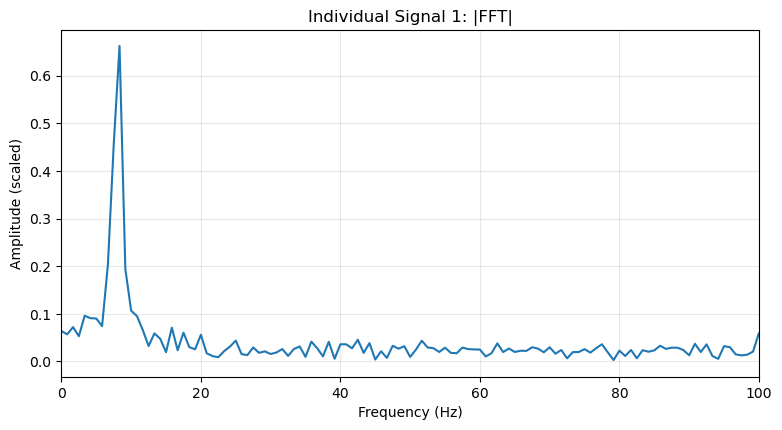

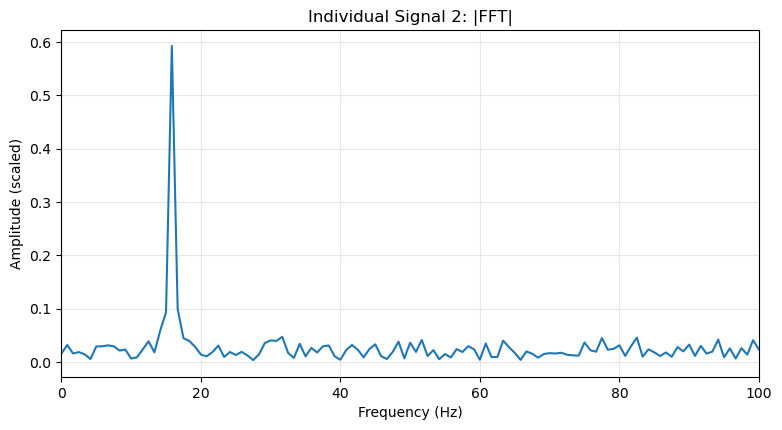

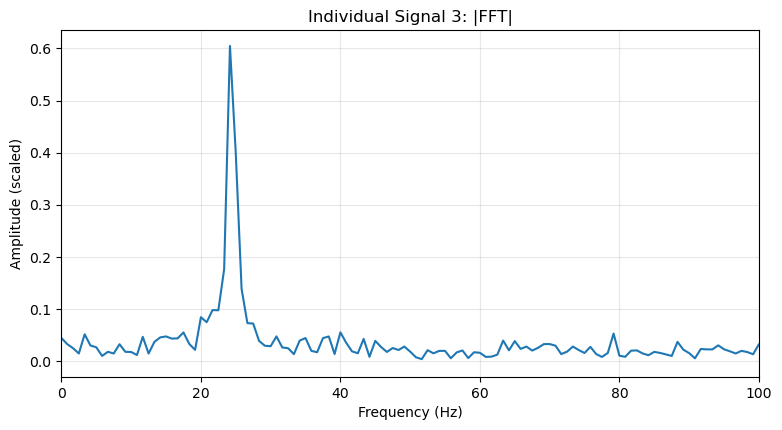

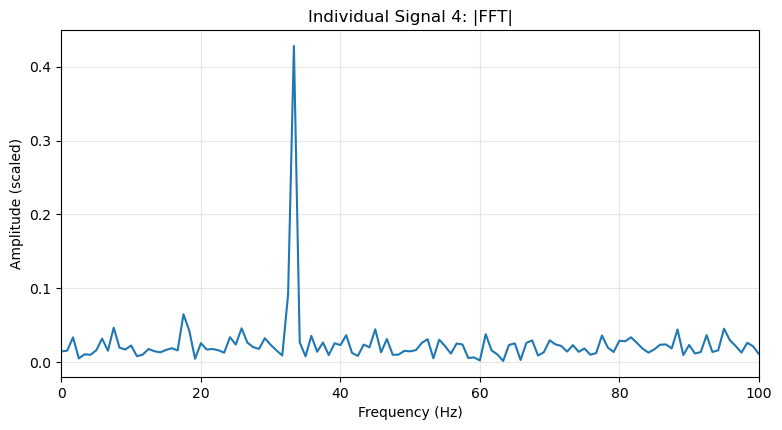

In [5]:
# -----------------------------
# 2b) Plot spectra for each individual signal
# -----------------------------
for i in range(4):
    f_i, X_i, mag_i = spectrum(signals[i])
    fig = plt.figure(figsize=(9, 4.5))
    plt.plot(f_i, mag_i/len(signals[i]))
    plt.title(f'Individual Signal {i+1}: |FFT|')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (scaled)')
    plt.xlim(0, 100)
    plt.grid(True, alpha=0.3)
    save_and_show(fig, f'./output/signal_{i+1}_spectrum.png')

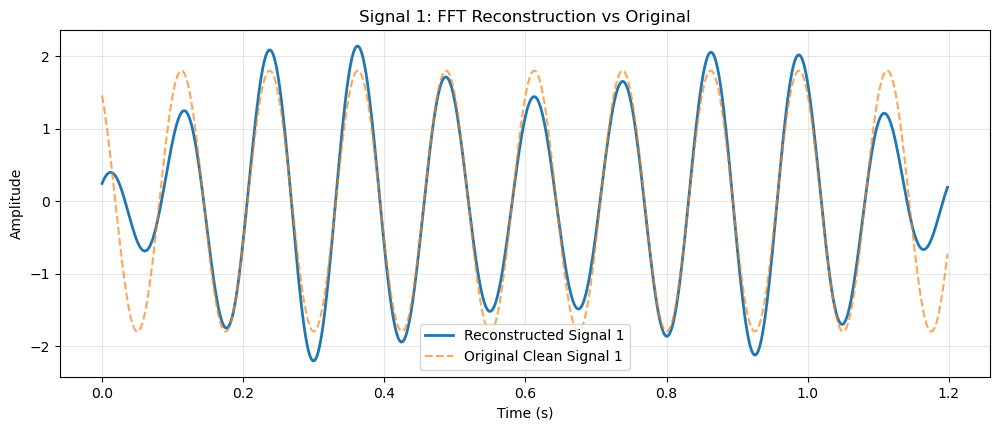

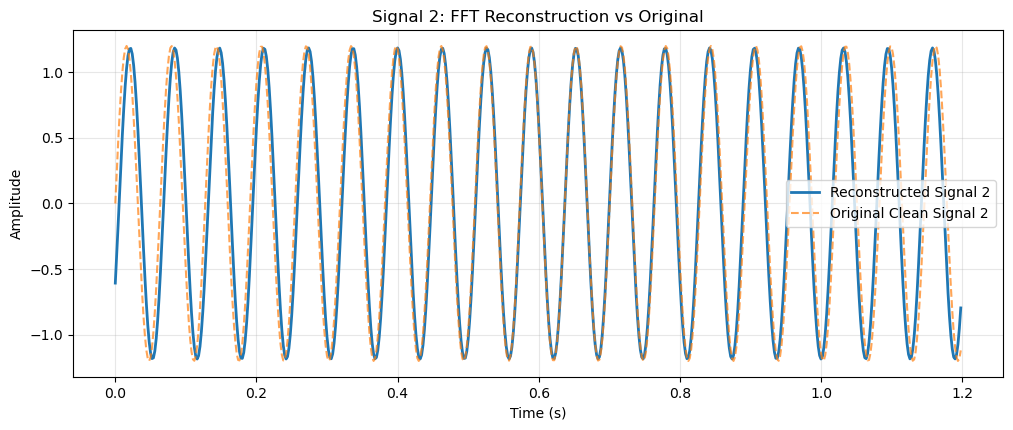

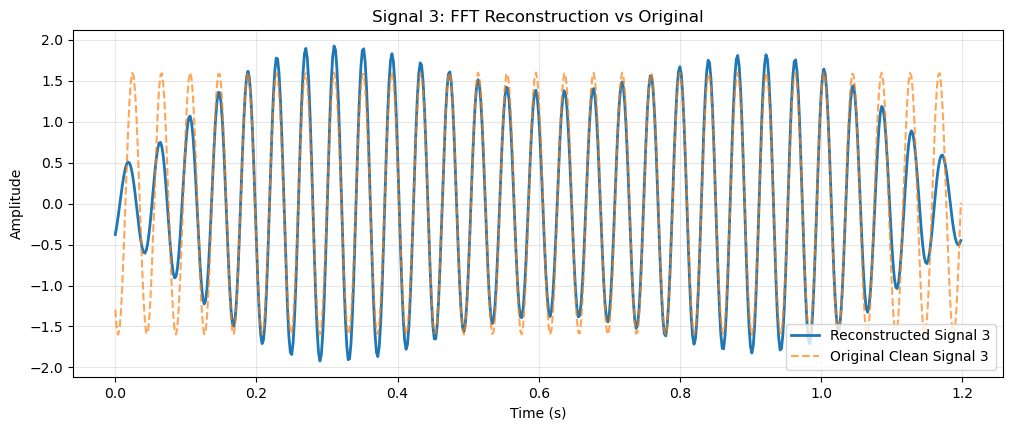

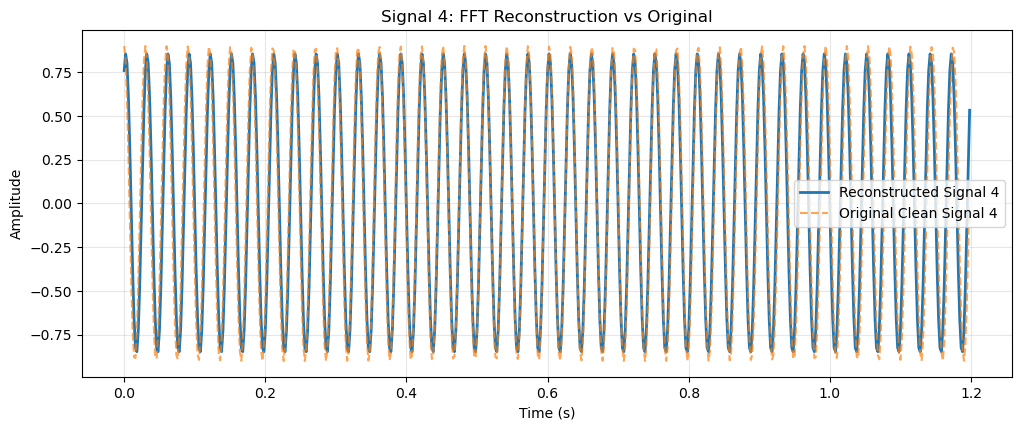

In [23]:
# Plot individual fingerprint sinusoids (reconstructed from FFT)
for i in range(4):
    fig = plt.figure(figsize=(12, 4.5))
    plt.plot(t, fingerprints[i], label=f'Reconstructed Signal {i+1}', linewidth=2)
    plt.plot(t, signals_clean[i], '--', alpha=0.7, label=f'Original Clean Signal {i+1}')
    plt.title(f'Signal {i+1}: FFT Reconstruction vs Original')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    save_and_show(fig, f'./output/fingerprint_signal_time_{i+1}.png')

In [6]:
# -----------------------------
# 3) FFT of each individual signal and "fingerprint" reconstruction
#    We'll reconstruct by zeroing out FFT bins below threshold, then irfft.
# -----------------------------
def pick_bins(mag, rel):
    thr = rel * np.max(mag)
    return mag >= thr

fingerprints = []    # time-domain reconstructed "main components" for each signal
peaks_info = []      # list of (freqs, mags) that were kept

for i in range(4):
    f, X, mag = spectrum(signals[i])
    keep = pick_bins(mag, peak_rel)
    X_kept = np.zeros_like(X, dtype=np.complex128)
    X_kept[keep] = X[keep]
    x_fp = irfft(X_kept, n=len(signals[i]))
    fingerprints.append(x_fp)

    # store kept freq indices for reporting
    peaks_info.append((f[keep], mag[keep]))

fingerprints = np.array(fingerprints)

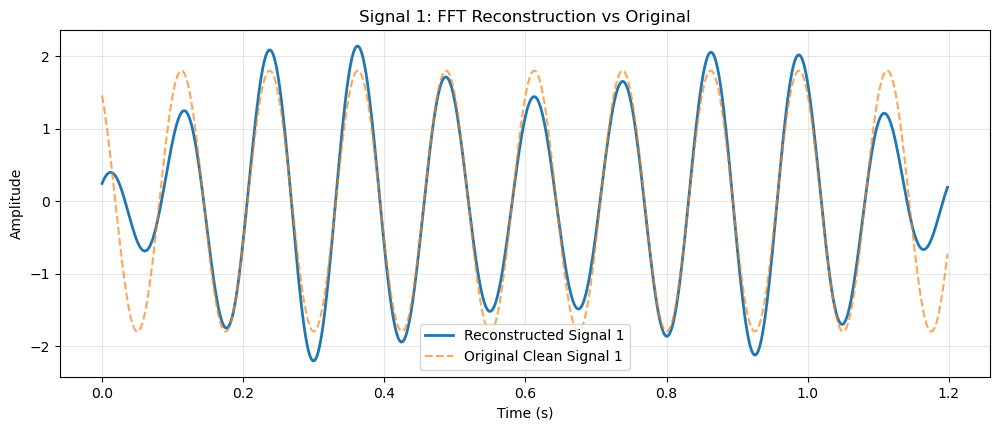

In [ ]:
for i in range(4):
    fig = plt.figure(figsize=(12, 4.5))
    plt.plot(t, fingerprints[i], label=f'Reconstructed Signal {i+1}', linewidth=2)
    plt.plot(t, signals_clean[i], '--', alpha=0.7, label=f'Original Clean Signal {i+1}')
    plt.title(f'Signal {i+1}: FFT Reconstruction vs Original')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    save_and_show(fig, f'./output/fingerprint_signal_time_{i+1}.png')
    break

In [7]:
# -----------------------------
# 4) Sum of signals and its spectrum
# -----------------------------
sum_signal = np.sum(signals, axis=0)
f_sum, X_sum, mag_sum = spectrum(sum_signal)

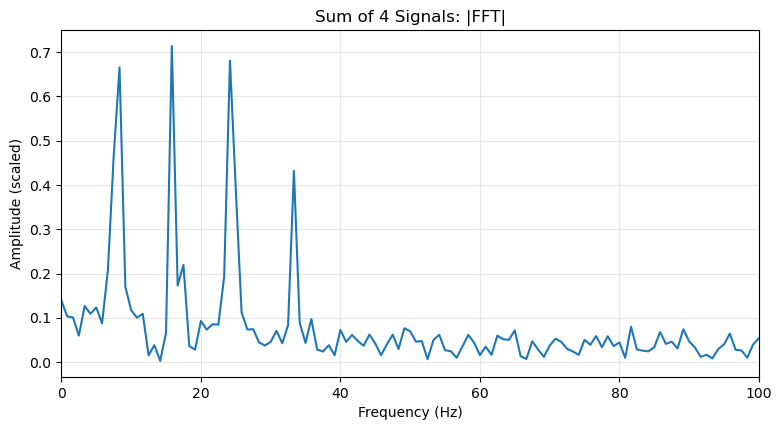

In [8]:
# -----------------------------
# 5) Plot sum spectrum
# -----------------------------
fig = plt.figure(figsize=(9, 4.5))
plt.plot(f_sum, mag_sum/len(sum_signal))
plt.title('Sum of 4 Signals: |FFT|')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (scaled)')
plt.xlim(0, 100)
plt.grid(True, alpha=0.3)
save_and_show(fig, './output/sum_spectrum.png')

In [9]:
# -----------------------------
# 5) Subtract fingerprints of the 4 signals from the sum (time-domain subtraction)
#    Residual should contain the hidden sinusoid + noise + any leakage
# -----------------------------
sum_fingerprint = np.sum(fingerprints, axis=0)
residual = sum_signal - sum_fingerprint
f_res, X_res, mag_res = spectrum(residual)

# Also compute spectrum of the *true* hidden trace actually injected into the sum,
# to compare with what we recovered. The actual injected signal into the sum equals
# hidden * 1 when choices[n] in {0,1,2,3}, else 0 when skipped -> i.e., a gated sinusoid.
gate = (choices < 4).astype(float)
hidden_in_sum = hidden * gate  # what the sum truly got from the hidden sinusoid
f_hid, X_hid, mag_hid = spectrum(hidden_in_sum)

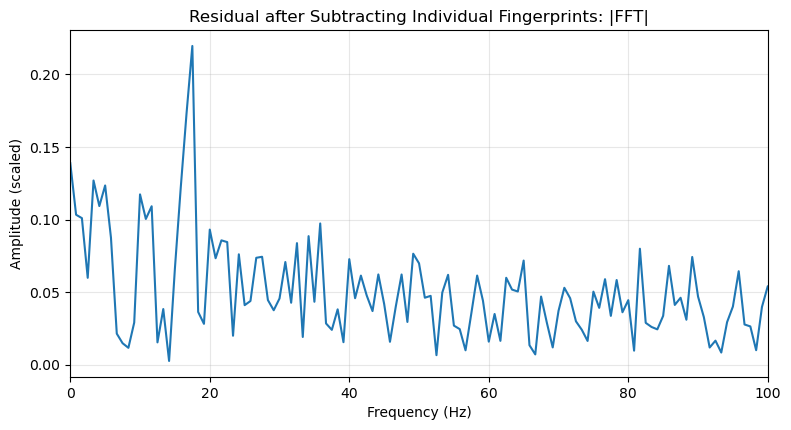

In [10]:
# -----------------------------
# 6) Plot residual spectrum (after subtracting fingerprints)
# -----------------------------
fig = plt.figure(figsize=(9, 4.5))
plt.plot(f_res, mag_res/len(residual))
plt.title('Residual after Subtracting Individual Fingerprints: |FFT|')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (scaled)')
plt.xlim(0, 100)
plt.grid(True, alpha=0.3)
save_and_show(fig, './output/residual_spectrum.png')

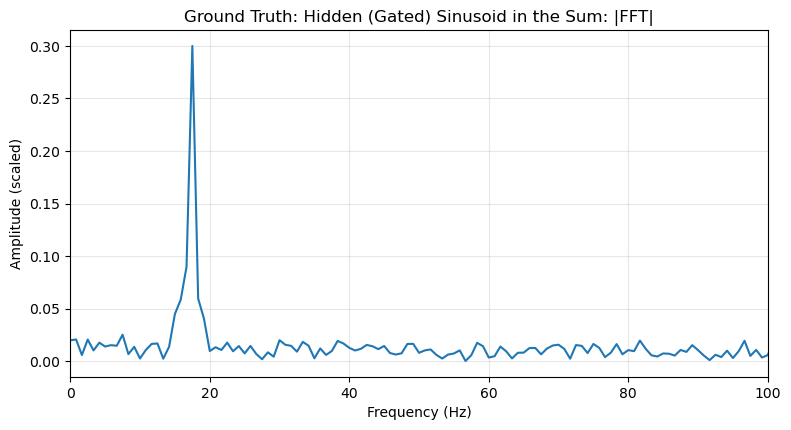

In [11]:
# -----------------------------
# 10) Plot spectrum of the actually injected hidden trace (gated 5th sinusoid)
# -----------------------------
fig = plt.figure(figsize=(9, 4.5))
plt.plot(f_hid, mag_hid/len(hidden_in_sum))
plt.title('Ground Truth: Hidden (Gated) Sinusoid in the Sum: |FFT|')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (scaled)')
plt.xlim(0, 100)
plt.grid(True, alpha=0.3)
save_and_show(fig, './output/hidden_in_sum_spectrum.png')

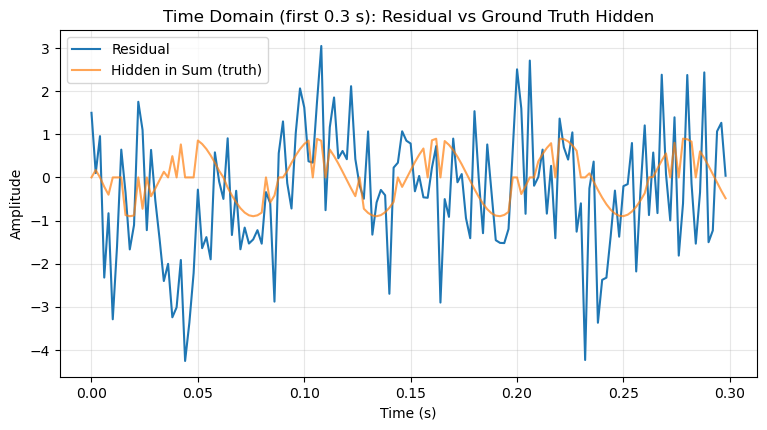

In [12]:
# -----------------------------
# 11) Time-domain quick looks: residual vs hidden_in_sum (first 0.3 s)
# -----------------------------
view = int(0.3 * fs)
fig = plt.figure(figsize=(9, 4.5))
plt.plot(t[:view], residual[:view], label='Residual')
plt.plot(t[:view], hidden_in_sum[:view], alpha=0.7, label='Hidden in Sum (truth)')
plt.title('Time Domain (first 0.3 s): Residual vs Ground Truth Hidden')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.legend()
save_and_show(fig, './output/residual_vs_hidden_time.png')

In [13]:
# -----------------------------
# 12) Report: top peaks found per individual, and strongest residual peaks
# -----------------------------
def top_peaks(f, mag, k=8, fmax=100.0):
    mask = (f > 0) & (f <= fmax)
    idx = np.argsort(mag[mask])[-k:][::-1]
    f_sel = f[mask][idx]
    a_sel = (mag[mask][idx] / len(mag))  # scaled
    return list(zip(f_sel, a_sel))

report = []
for i in range(4):
    f_i, X_i, mag_i = spectrum(signals[i])
    report.append(("Signal {}".format(i+1), top_peaks(f_i, mag_i, k=8)))

res_top = top_peaks(f_res, mag_res, k=8)
hid_top = top_peaks(f_hid, mag_hid, k=8)

report_text = []
for name, peaks in report:
    report_text.append(f"=== {name} top peaks ===")
    for fr, amp in peaks:
        report_text.append(f"  {fr:6.2f} Hz | {amp:.4f}")
report_text.append("\n=== Residual top peaks ===")
for fr, amp in res_top:
    report_text.append(f"  {fr:6.2f} Hz | {amp:.4f}")
report_text.append("\n=== Ground truth hidden-in-sum top peaks ===")
for fr, amp in hid_top:
    report_text.append(f"  {fr:6.2f} Hz | {amp:.4f}")

# Save text report
with open('./output/fft_report.txt', 'w') as f:
    f.write("\n".join(report_text))

print("\n".join(report_text))

=== Signal 1 top peaks ===
    8.33 Hz | 1.3212
    7.50 Hz | 0.9073
    6.67 Hz | 0.4057
    9.17 Hz | 0.3869
   10.00 Hz | 0.2128
    3.33 Hz | 0.1914
   10.83 Hz | 0.1900
    4.17 Hz | 0.1813
=== Signal 2 top peaks ===
   15.83 Hz | 1.1813
   16.67 Hz | 0.1978
   15.00 Hz | 0.1854
   14.17 Hz | 0.1172
   31.67 Hz | 0.0941
   82.50 Hz | 0.0910
   77.50 Hz | 0.0896
   17.50 Hz | 0.0887
=== Signal 3 top peaks ===
   24.17 Hz | 1.2054
   25.00 Hz | 0.7947
   23.33 Hz | 0.3518
   25.83 Hz | 0.2765
   21.67 Hz | 0.1957
   22.50 Hz | 0.1949
   20.00 Hz | 0.1684
   20.83 Hz | 0.1493
=== Signal 4 top peaks ===
   33.33 Hz | 0.8534
   32.50 Hz | 0.1822
   17.50 Hz | 0.1290
    7.50 Hz | 0.0929
   25.83 Hz | 0.0911
   95.00 Hz | 0.0901
   45.00 Hz | 0.0884
   88.33 Hz | 0.0881

=== Residual top peaks ===
   17.50 Hz | 0.4375
   16.67 Hz | 0.3448
    3.33 Hz | 0.2529
    5.00 Hz | 0.2461
   15.83 Hz | 0.2426
   10.00 Hz | 0.2339
    4.17 Hz | 0.2178
   11.67 Hz | 0.2176

=== Ground truth hidden

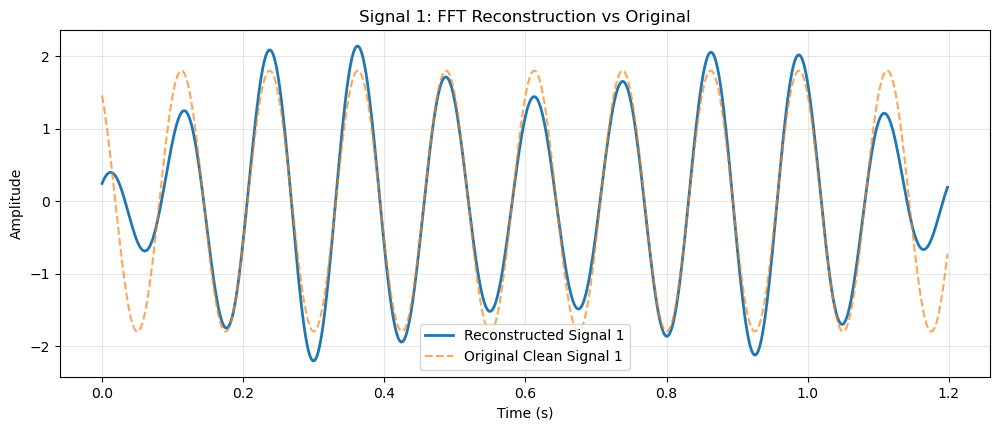

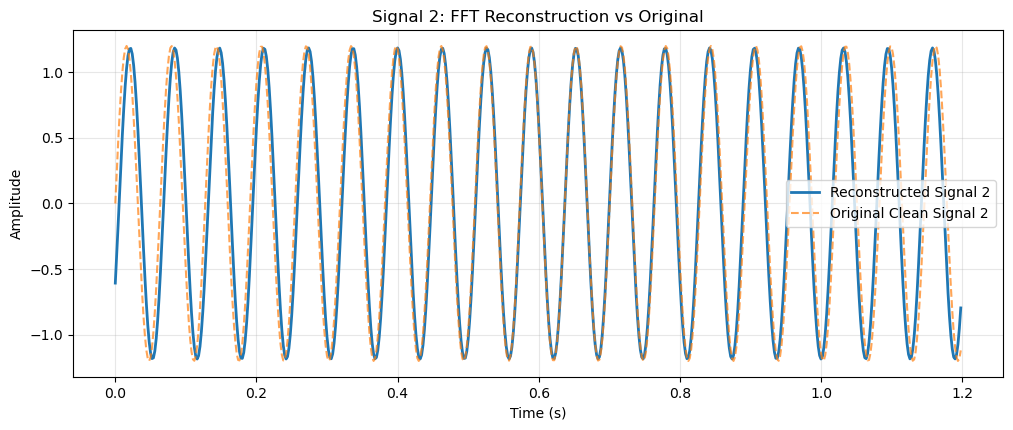

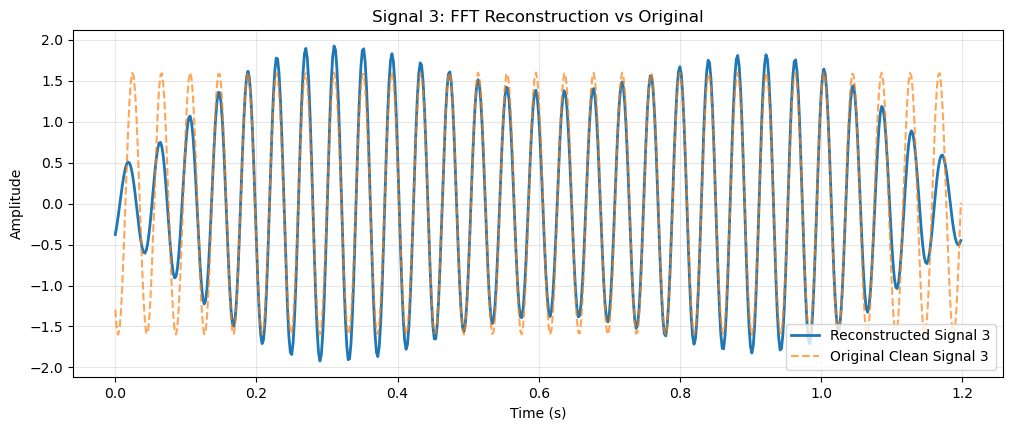

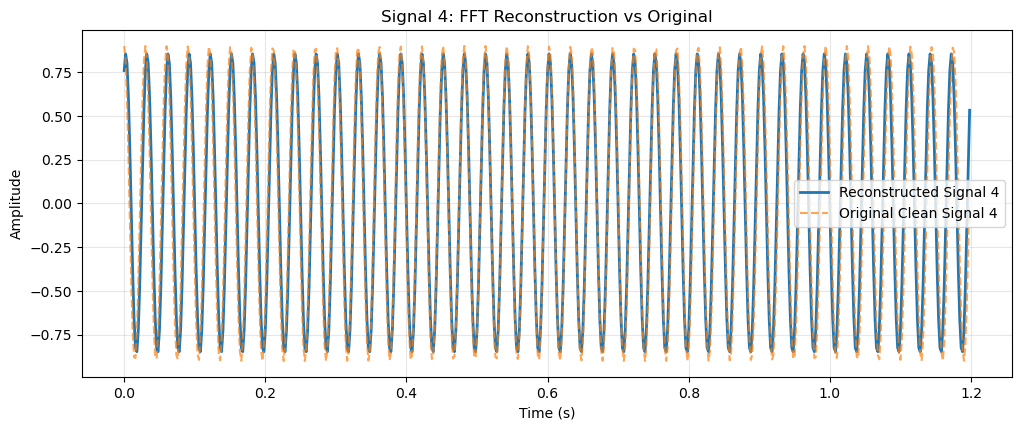

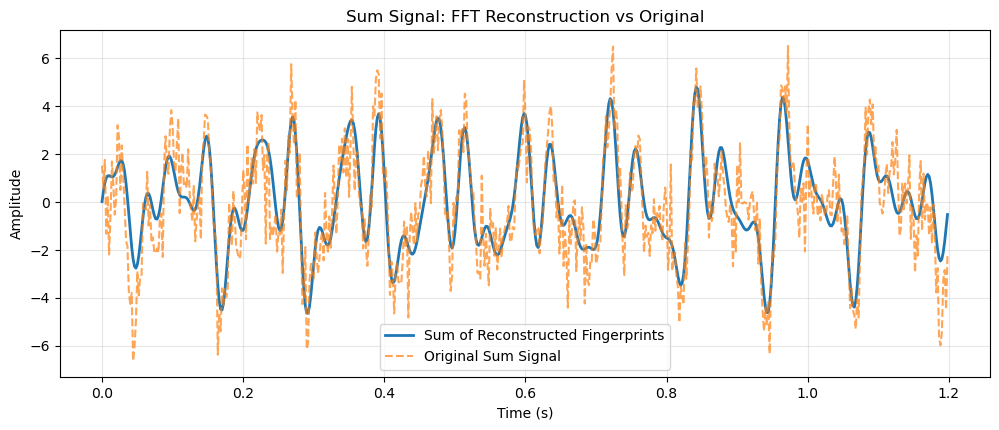

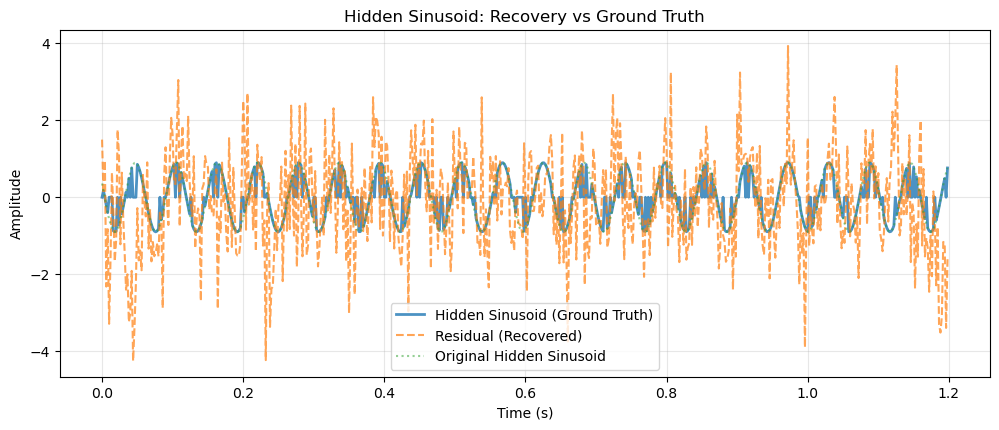

In [21]:
# -----------------------------
# 13) Plot reconstructed sinusoids from FFT results
# -----------------------------

# Plot individual fingerprint sinusoids (reconstructed from FFT)
for i in range(4):
    fig = plt.figure(figsize=(12, 4.5))
    plt.plot(t, fingerprints[i], label=f'Reconstructed Signal {i+1}', linewidth=2)
    plt.plot(t, signals_clean[i], '--', alpha=0.7, label=f'Original Clean Signal {i+1}')
    plt.title(f'Signal {i+1}: FFT Reconstruction vs Original')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(True, alpha=0.3)
    save_and_show(fig, f'./output/fingerprint_signal_time_{i+1}.png')

# Plot the sum of all fingerprints vs original sum
fig = plt.figure(figsize=(12, 4.5))
plt.plot(t, sum_fingerprint, label='Sum of Reconstructed Fingerprints', linewidth=2)
plt.plot(t, sum_signal, '--', alpha=0.7, label='Original Sum Signal')
plt.title('Sum Signal: FFT Reconstruction vs Original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
save_and_show(fig, './output/fingerprint_sum_time.png')

# Plot the hidden sinusoid reconstruction
fig = plt.figure(figsize=(12, 4.5))
plt.plot(t, hidden_in_sum, label='Hidden Sinusoid (Ground Truth)', linewidth=2, alpha=0.8)
plt.plot(t, residual, '--', alpha=0.7, label='Residual (Recovered)')
plt.plot(t, hidden, ':', alpha=0.5, label='Original Hidden Sinusoid')
plt.title('Hidden Sinusoid: Recovery vs Ground Truth')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)
save_and_show(fig, './output/hidden_recovery_comparison.png')

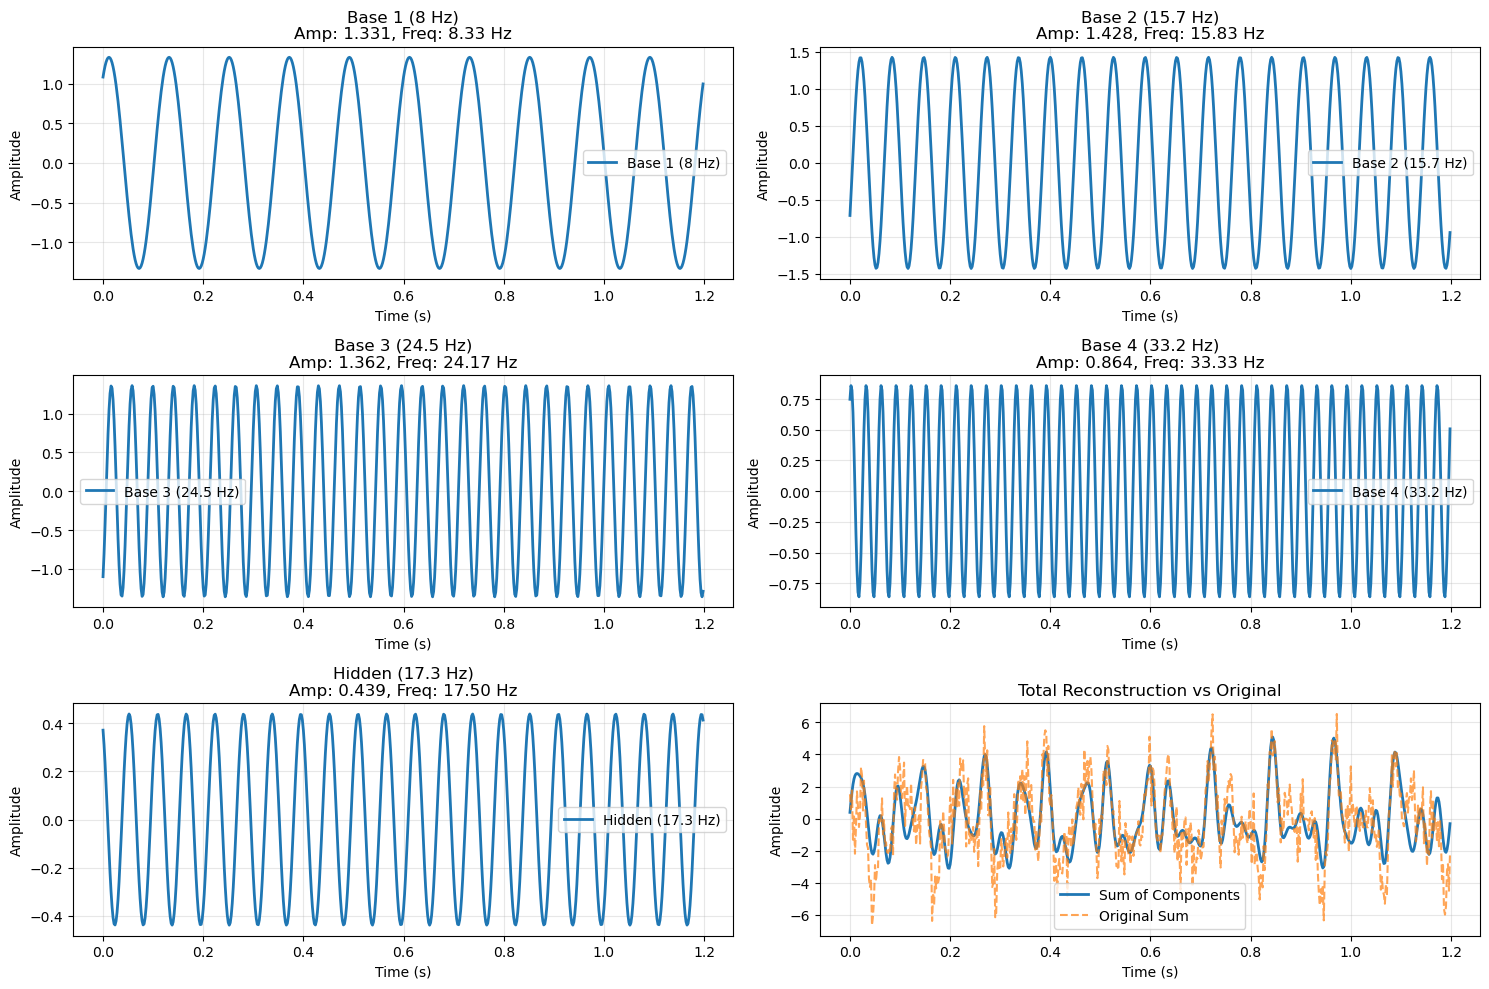

In [22]:
# -----------------------------
# 14) Extract and plot individual frequency components as sinusoids
# -----------------------------

def extract_sinusoid_from_fft(freq_array, magnitude_array, complex_array, target_freq, freq_tolerance=0.5):
    """Extract a single sinusoid component from FFT data"""
    # Find the frequency bin closest to target frequency
    freq_mask = np.abs(freq_array - target_freq) <= freq_tolerance
    if not np.any(freq_mask):
        return np.zeros_like(t), 0, 0
    
    # Get the dominant frequency component
    idx = np.where(freq_mask)[0]
    max_idx = idx[np.argmax(magnitude_array[idx])]
    
    # Extract amplitude and phase
    amplitude = 2 * magnitude_array[max_idx] / len(t)  # Scale back to original amplitude
    phase = np.angle(complex_array[max_idx])
    actual_freq = freq_array[max_idx]
    
    # Reconstruct sinusoid
    sinusoid = amplitude * np.cos(2 * np.pi * actual_freq * t + phase)
    return sinusoid, amplitude, actual_freq

# Plot individual frequency components from the sum signal
fig = plt.figure(figsize=(15, 10))

# Extract the main frequency components from the sum signal
main_frequencies = [8.0, 15.7, 24.5, 33.2, 17.3]  # Including the hidden frequency
component_names = ['Base 1 (8 Hz)', 'Base 2 (15.7 Hz)', 'Base 3 (24.5 Hz)', 'Base 4 (33.2 Hz)', 'Hidden (17.3 Hz)']

reconstructed_components = []
for i, (freq, name) in enumerate(zip(main_frequencies, component_names)):
    sinusoid, amp, actual_freq = extract_sinusoid_from_fft(f_sum, mag_sum, X_sum, freq)
    reconstructed_components.append(sinusoid)
    
    plt.subplot(3, 2, i+1)
    plt.plot(t, sinusoid, linewidth=2, label=f'{name}')
    plt.title(f'{name}\nAmp: {amp:.3f}, Freq: {actual_freq:.2f} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.grid(True, alpha=0.3)
    plt.legend()

# Plot the sum of all reconstructed components
plt.subplot(3, 2, 6)
total_reconstructed = np.sum(reconstructed_components, axis=0)
plt.plot(t, total_reconstructed, linewidth=2, label='Sum of Components')
plt.plot(t, sum_signal, '--', alpha=0.7, label='Original Sum')
plt.title('Total Reconstruction vs Original')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
save_and_show(fig, './output/individual_sinusoid_components.png')